In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os

In [2]:
image_path_train = "marble/train/good"
image_path_ok = "marble/test/good"

In [3]:
BATCH_SIZE = 16
N_EPOCHS = 10
LEARNING_RATE = 1e-3
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"The device is {DEVICE}.")

The device is cpu.


In [4]:
from numpy import copy


class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=2, padding=1),  # 64 -> 32
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # 32 -> 16
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1), # 16 -> 8
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1), # 8 -> 16
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), # 16 -> 32
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 3, stride=2, padding=1, output_padding=1),  # 32 -> 64
            nn.Sigmoid(),  # output in [0,1]
        )

    def forward(self, x):
        x = self.encoder(x)
        self.latent_space = copy(x.detach().numpy())
        x = self.decoder(x)
        return x

In [ ]:
import math


class ConvAutoencoder(nn.Module):
    def __init__(self, input_size=128, img_channels=3, feature_dim=256):
        super(ConvAutoencoder, self).__init__()

        assert math.log2(input_size).is_integer(), "Input size must be a power of 2 (e.g., 64, 128, 256)"
        self.input_size = input_size

        # Build encoder dynamically
        layers = []
        channels = [img_channels, 16, 32, 64, 128]
        size = input_size
        for i in range(len(channels) - 1):
            layers.append(nn.Conv2d(channels[i], channels[i+1], kernel_size=4, stride=2, padding=1))
            layers.append(nn.ReLU(True))
            size //= 2  # downsampling step

        self.encoder_conv = nn.Sequential(*layers)
        self.flattened_size = channels[-1] * size * size
        self.encoder_fc = nn.Linear(self.flattened_size, feature_dim)

        # Decoder
        self.decoder_fc = nn.Linear(feature_dim, self.flattened_size)

        # Build decoder (inverse of encoder)
        decoder_layers = []
        channels = list(reversed(channels))
        for i in range(len(channels) - 1):
            decoder_layers.append(nn.ConvTranspose2d(
                channels[i], channels[i+1], kernel_size=4, stride=2, padding=1))
            if i < len(channels) - 2:
                decoder_layers.append(nn.ReLU(True))
            else:
                decoder_layers.append(nn.Tanh())  # final layer

        self.decoder_conv = nn.Sequential(*decoder_layers)

    def forward(self, x):
        x = self.encoder_conv(x)
        x = x.view(x.size(0), -1)
        z = self.encoder_fc(x)

        x = self.decoder_fc(z)
        x = x.view(x.size(0), -1, self.input_size // (2 ** 4), self.input_size // (2 ** 4))  # 4 conv layers
        x = self.decoder_conv(x)
        return x


In [6]:
IMAGE_SIZE = 128

transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])


In [7]:
class MarbleImageDataset(Dataset):
    def __init__(self, img_dir, transform=None, target_transform=None, val=False):
        self.img_dir = img_dir
        self.image_names = os.listdir(self.img_dir)
        val_len = int(len(self.image_names) * 0.2)
        if val:
            # last 20% are validation images
            self.image_names = self.image_names[-val_len:]
        else:
            # everything before last 20% are training images
            self.image_names = self.image_names[:-val_len]
            
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.image_names[idx])
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)
        return image

In [8]:
train_dataset = MarbleImageDataset(image_path_train, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)


In [9]:
val_dataset = MarbleImageDataset(image_path_train, transform=transform, val=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)


In [ ]:
from tqdm import tqdm

# model = Autoencoder().to(DEVICE)
model = ConvAutoencoder(input_size=IMAGE_SIZE).to(DEVICE)
if os.path.exists("model.pth"):
    model.load_state_dict(torch.load("model.pth", weights_only=True))
else:
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    losses = []
    batch_losses = []

    for epoch in range(N_EPOCHS):
        model.train()
        total_loss = 0
        for imgs in tqdm(train_loader, desc=f"Epoch {epoch+1}/{N_EPOCHS}"):
            imgs = imgs.to(DEVICE)
            outputs = model(imgs)
            loss = criterion(outputs, imgs)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            batch_losses.append(loss.item())

        mean_loss = total_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{N_EPOCHS}], Loss: {mean_loss:.6f}")
        losses.append(mean_loss)
        

Epoch 1/10: 100%|██████████| 43/43 [00:28<00:00,  1.53it/s]


Epoch [1/10], Loss: 0.035755


Epoch 2/10: 100%|██████████| 43/43 [00:27<00:00,  1.58it/s]


Epoch [2/10], Loss: 0.005177


Epoch 3/10: 100%|██████████| 43/43 [00:28<00:00,  1.52it/s]


Epoch [3/10], Loss: 0.004782


Epoch 4/10: 100%|██████████| 43/43 [00:27<00:00,  1.56it/s]


Epoch [4/10], Loss: 0.003458


Epoch 5/10: 100%|██████████| 43/43 [00:26<00:00,  1.61it/s]


Epoch [5/10], Loss: 0.005468


Epoch 6/10: 100%|██████████| 43/43 [00:27<00:00,  1.57it/s]


Epoch [6/10], Loss: 0.002321


Epoch 7/10: 100%|██████████| 43/43 [00:27<00:00,  1.55it/s]


Epoch [7/10], Loss: 0.002111


Epoch 8/10: 100%|██████████| 43/43 [00:25<00:00,  1.67it/s]


Epoch [8/10], Loss: 0.001952


Epoch 9/10: 100%|██████████| 43/43 [00:26<00:00,  1.65it/s]


Epoch [9/10], Loss: 0.001848


Epoch 10/10: 100%|██████████| 43/43 [00:24<00:00,  1.74it/s]

Epoch [10/10], Loss: 0.001747


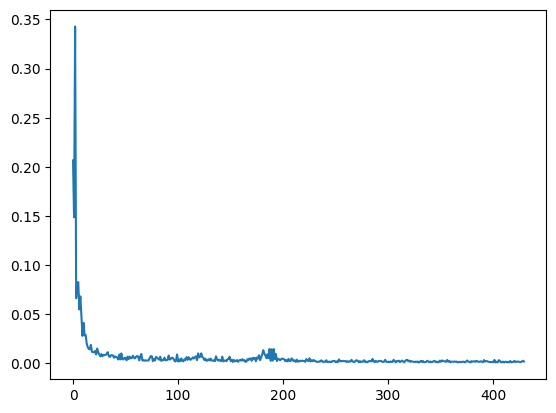

In [ ]:
plt.plot(batch_losses)

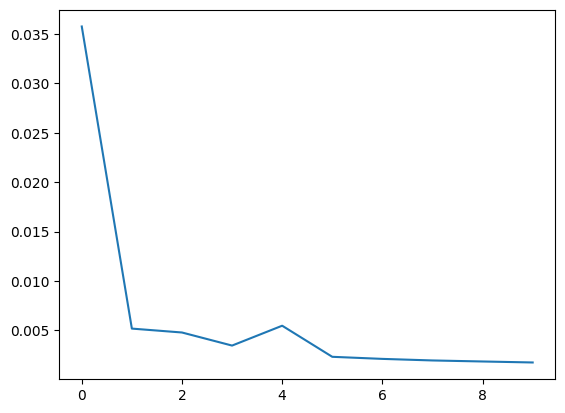

In [12]:
plt.plot(losses)

In [13]:
def compare_orig_and_reconstructed(orig, recon):
    # Revert normalization
    orig = (orig + 1) / 2
    recon = (recon + 1) / 2

    plt.subplot(1, 2, 1)
    plt.title("Original")
    plt.imshow(np.transpose(orig[0], (1, 2, 0)))
    plt.subplot(1, 2, 2)
    plt.title("Reconstructed")
    plt.imshow(np.transpose(recon[0], (1, 2, 0)))
    plt.show()

In [14]:
def compute_reconstruction_error_from_path(img_path):
    img = Image.open(img_path)
    img_tensor = transform(img).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        output = model(img_tensor)
    loss = criterion(output, img_tensor).item()
    return loss, img_tensor.cpu(), output.cpu()

In [21]:
import torch.nn.functional as F

def compute_reconstruction_error(original, reconstructed):
    # Mean squared error per sample
    errors = F.mse_loss(reconstructed, original, reduction='none')
    errors = errors.view(errors.size(0), -1).mean(dim=1)  # (B,)
    return errors

In [22]:
# Run model on validation set
model.eval()
all_errors = []
with torch.no_grad():
    for batch in val_loader:
        imgs = batch.to(DEVICE)
        recon = model(imgs)
        errors = compute_reconstruction_error(imgs, recon)
        all_errors.extend(errors.cpu().numpy())

# Set threshold to 95th percentile of normal reconstruction error
import numpy as np
threshold = np.percentile(all_errors, 95)
threshold

np.float32(0.007349099)

Reconstruction error: 0.0018


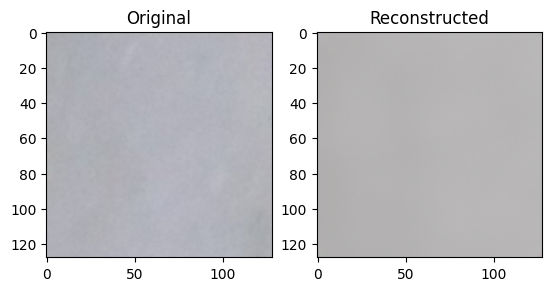

Reconstruction error: 0.1455


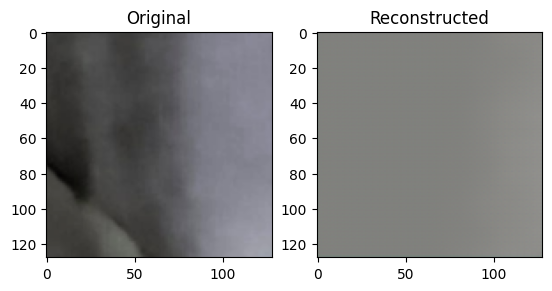

Reconstruction error: 0.0083


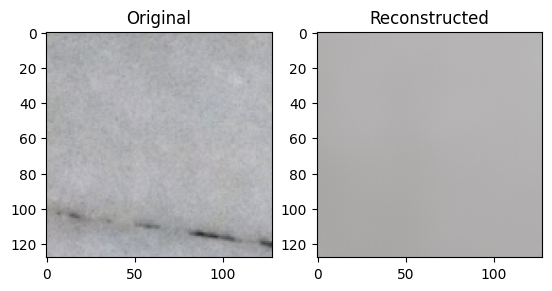

Reconstruction error: 0.0018


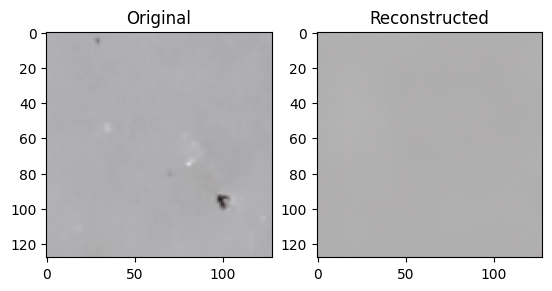

In [24]:
# Example
error, orig, recon = compute_reconstruction_error_from_path("marble/test/good/_0_0_20210525_15434.jpg")
print(f"Reconstruction error: {error:.4f}")
compare_orig_and_reconstructed(orig, recon)

error, orig, recon = compute_reconstruction_error_from_path("marble/test/crack/_0_0_20210531_17292_0.jpg")
print(f"Reconstruction error: {error:.4f}")
compare_orig_and_reconstructed(orig, recon)

error, orig, recon = compute_reconstruction_error_from_path("marble/test/joint/_0_4352_20210525_15441_1.jpg")
print(f"Reconstruction error: {error:.4f}")
compare_orig_and_reconstructed(orig, recon)

error, orig, recon = compute_reconstruction_error_from_path("marble/test/dot/_0_2560_20210531_10521_2.jpg")
print(f"Reconstruction error: {error:.4f}")
compare_orig_and_reconstructed(orig, recon)

In [25]:
from numpy import mean


def compute_mean_reconstruction_error(directory, error_thresh = None):
    recon_errors = []
    for file_name in os.listdir(directory):
        error, orig, recon = compute_reconstruction_error_from_path(os.path.join(directory, file_name))
        if error_thresh is not None:
            if error > error_thresh:
                print(error)
                compare_orig_and_reconstructed(orig, recon)
        recon_errors.append(error)
    return mean(recon_errors), min(recon_errors), max(recon_errors)

In [26]:
threshold

np.float32(0.007349099)

In [27]:
print(compute_mean_reconstruction_error("marble/test/good"))
print(compute_mean_reconstruction_error("marble/test/crack"))
print(compute_mean_reconstruction_error("marble/test/joint"))
print(compute_mean_reconstruction_error("marble/test/dot"))

(np.float64(0.0017321118794771952), 0.00023523985873907804, 0.0193288866430521)
(np.float64(0.0344894530807671), 0.00037860823795199394, 0.3649040758609772)
(np.float64(0.01596472658234222), 0.0005765539826825261, 0.15989887714385986)
(np.float64(0.01009026396335183), 0.0004242798313498497, 0.07092299312353134)


In [30]:
def is_anomaly(original, reconstructed, threshold):
    errors = compute_reconstruction_error(original, reconstructed).cpu().numpy()
    return errors > threshold  # Boolean tensor

In [31]:
results = {
    "marble/test/good": {"tp": 0, "tn": 0, "fp": 0, "fn": 0, "total": 0},
    "marble/test/crack": {"tp": 0, "tn": 0, "fp": 0, "fn": 0, "total": 0},
    "marble/test/joint": {"tp": 0, "tn": 0, "fp": 0, "fn": 0, "total": 0},
    "marble/test/dot": {"tp": 0, "tn": 0, "fp": 0, "fn": 0, "total": 0},
}

for directory, anomaly in [
    ("marble/test/good", False),
    ("marble/test/crack", True),
    ("marble/test/joint", True),
    ("marble/test/dot", True),
]:
    for img_path in os.listdir(directory):
        img = Image.open(os.path.join(directory, img_path))
        img_tensor = transform(img).unsqueeze(0).to(DEVICE)
        with torch.no_grad():
            output = model(img_tensor)
        pred = is_anomaly(img_tensor, output, threshold=threshold)
        results[directory]["total"] += 1
        if anomaly:
            if pred:
                results[directory]["tp"] += 1
            else:
                results[directory]["fn"] += 1
        else:
            if pred:
                results[directory]["fp"] += 1
            else:
                results[directory]["tn"] += 1

In [ ]:
results

{'marble/test/good': {'tp': 0, 'tn': 328, 'fp': 12, 'fn': 0, 'total': 340},
 'marble/test/crack': {'tp': 173, 'tn': 0, 'fp': 0, 'fn': 73, 'total': 246},
 'marble/test/joint': {'tp': 45, 'tn': 0, 'fp': 0, 'fn': 33, 'total': 78},
 'marble/test/dot': {'tp': 9, 'tn': 0, 'fp': 0, 'fn': 15, 'total': 24}}

In [33]:
model.encoder_conv

Sequential(
  (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (5): ReLU(inplace=True)
  (6): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (7): ReLU(inplace=True)
)

In [34]:
model.decoder_conv

Sequential(
  (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (5): ReLU(inplace=True)
  (6): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (7): Tanh()
)

In [36]:
torch.save(model.state_dict(), "model.pth")